mne.io.read_raw_edf: Loads the file and read the data

raw.info 

In [1]:
import sys
print(sys.executable)

%matplotlib qt


c:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\.venv\Scripts\python.exe


Using Python executable: c:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\.venv\Scripts\python.exe
Extracting EDF parameters from C:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\physionet.org\files\eegmmidb\1.0.0\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1919  =      0.000 ...    11.994 secs...

--- Data Info ---
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>

--- Channel Names ---
Channels: ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4

C:\Users\524yu\AppData\Local\Temp\ipykernel_17032\3038758719.py:12: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = mne.io.read_raw_edf(physionet_file_path, preload=True)
C:\Users\524yu\AppData\Local\Temp\ipykernel_17032\3038758719.py:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(physionet_file_path, preload=True)


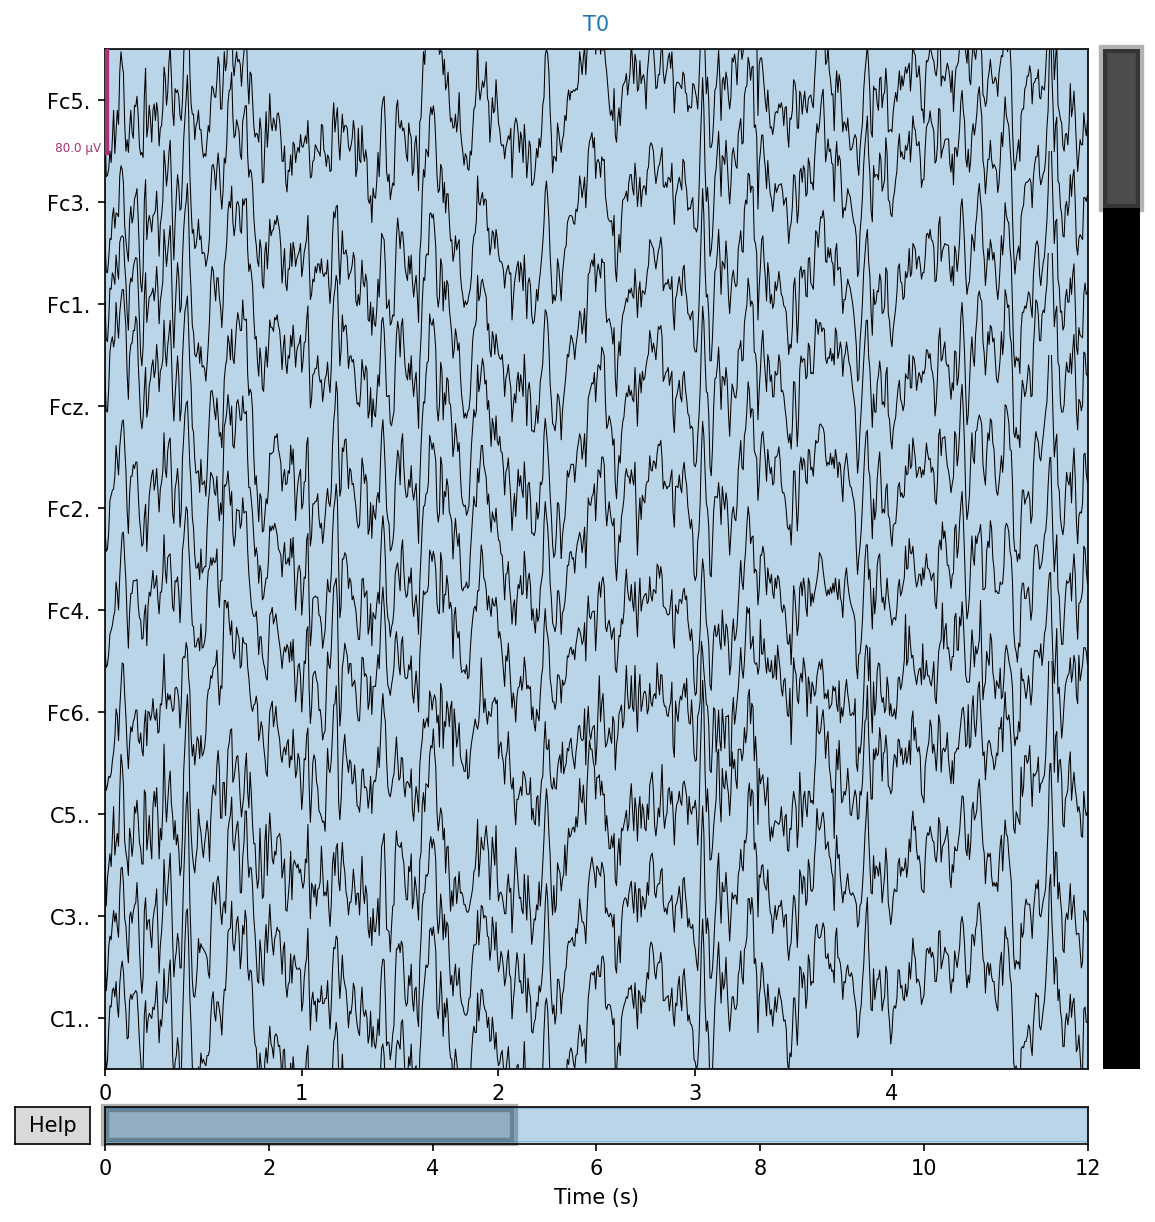

Channels marked as bad:
none


In [ ]:
import mne
import sys

print(f"Using Python executable: {sys.executable}")

# MNE will automatically download this file and store it in your home directory
# in a folder called 'mne_data'.
physionet_file_path = r'C:\Users\524yu\OneDrive\Documents\VSCODEE\BMI-Robotic-Control\physionet.org\files\eegmmidb\1.0.0\S001\S001R01.edf'

# Load the EEG data
# preload=True loads the data into memory
raw = mne.io.read_raw_edf(physionet_file_path, preload=True)

# Print basic information about the file
print("\n--- Data Info ---")
print(raw.info)


channel_subgroups = {
    "Frontal": [ch for ch in raw.ch_names if ch.startswith(("F", "Fp"))],
    "Central": [ch for ch in raw.ch_names if ch.startswith(("C"))],
    "Parietal": [ch for ch in raw.ch_names if ch.startswith(("P"))],
    "Occipital": [ch for ch in raw.ch_names if ch.startswith(("O"))],
    "Temporal": [ch for ch in raw.ch_names if ch.startswith(("T", "Tp"))]
}


# List available channel names
print ("--Channel Names--")

for regions, channels in channel_subgroups.items():
    if not channels:
        continue
    
    print (f"\n {regions}, Region: ({len(channels)} channels): ")
    print (f", ".join(channels))



# Show duration
duration_in_seconds = raw.n_times / raw.info['sfreq']
print(f"\nDuration: {duration_in_seconds:.2f} seconds")

# Plot a short segment to visualize
# This will open an interactive plot window.
print("\nOpening interactive plot for the first 5 seconds...")

for regions, channels in channel_subgroups.items():
    if not channels:
        continue
    print (f"showing regions: {regions}\n Channels shown: {len(channels)} channels: {channels}")
    raw.plot(picks = channels, duration= 5, n_channels=len(channels, scalings = "auto", title = f"{regions} Region EEG"))